In [9]:
import pandas as pd
import numpy as np
import math
import calendar
import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse 
sns.set()

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from matplotlib import pyplot


import warnings
warnings.filterwarnings("ignore")

In [10]:
# Здесь будем тестить точность прогнозных моделей

In [11]:
def create_pred_features(data, period = 12):
    """
    в данной функции генерируем признаки на период предсказания
    На вход принимаем датафрейм на базе которого обучаем модель
    """
    data = pd.DataFrame(data)
    # добавляем столбец с датой, перводим в datetime и отправляем в индекс
    data.columns = ['date', 'PO', 'temp_C']
    data.drop(['temp_C'], axis = 1, inplace = True)
    data['date'] = pd.to_datetime(data['date'], dayfirst = True)
    data.index = data['date']
    
    # добавляем номер месяца
    data['month'] = data.index.month
    # добавляем столбец с годом
    data['year'] = data.index.year
 

    #попробуем добавить тренд и сезонность
    # применяем seasonal_decompose
    # эта функция разложит ряд на трендовую, сезонную и шумовую составляющие
    decomposition = seasonal_decompose(data['PO'], model='additive', extrapolate_trend = 1) 
    data['PO_trend'] = decomposition.trend
    data['PO_trend'][0] = data['PO_trend'][1] - data['PO_trend'][1:].diff().mean()
    data['PO_seasonal'] = decomposition.seasonal
    data_grouped = data.groupby('month').mean()
    data['PO_seasonal'][0] = data_grouped['PO_seasonal'].iloc[0]
    
    for i in range(period):
        data = data.append(pd.Series(), ignore_index = True)
    for i in range(-1*period,0):
        data['PO_trend'].iloc[i] = data['PO_trend'].iloc[i-1] + data['PO_trend'].iloc[1:-1*period].diff().mean()
        data['month'].iloc[i] = data['month'].iloc[i-1]%12 + 1
        data['year'].iloc[i] = data['year'].iloc[i-12] + 1
        data['date'].iloc[i] = str(int(data['year'].iloc[i])) + '-' + str(int(data['month'].iloc[i])) + '-01'
        data['PO_seasonal'].iloc[i] = data_grouped[data_grouped.index == data['month'].iloc[i]]['PO_seasonal'].iloc[0]
        

    data['prognos'] = data['PO_trend'] + data['PO_seasonal']
    data['date'] = pd.to_datetime(data['date'], dayfirst = True)
    data.index = data['date']
    
    return data

In [12]:
# Сделаем предсказание на k--год (основа 2016-2021)
# прогнозируемый период - кол-во месяцев
period = 12

path = r"C:\Гарант\прогнозирование\Население\test_folder\\"

# посмотрим, что будет, если в качестве предсказания взять прогноз, который складывается из тренда и сезонности

# заберем все фалы из папок test-folder
files_list = []
for root, dirs, files in os.walk(path):  
    for filename in files:
        files_list.append(filename)

# загоним названия файлов экселя в список
files_excel = []
for file in files_list:
  if 'xlsx' in file and '~' not in file and 'prognos' not in file:
    files_excel.append(file)
    

predict = pd.DataFrame()
for file in files_excel:
    df = pd.read_excel(path + file)
    
    
    # проверочный блок
#    y_test = df.iloc[-12:,1]
#    df = df[:-12]
    df = create_pred_features(df, period)
   

    
    y_pred = df['prognos'][-1*period:]
    
    name = file.split('.')[0]
    predict[name+'_ПО_прогноз'] = y_pred
    
    #если делаем прогноз - надо закоментить:
#    print(file.split('.')[0])
#    print('MAE = {:.2f}'.format(mae(y_pred,y_test)))
#    print('MAPE = {:.3f}'.format(mape(y_pred,y_test)))
    
#сохраним полученные данные в файл
predict.to_excel(excel_writer = path+'prognos_seasonal_trend_next_period.xlsx')
 


Владимир


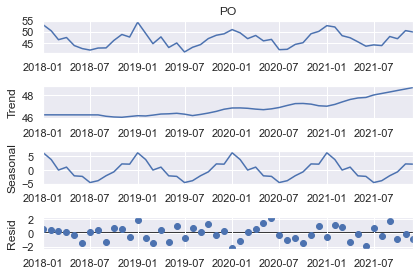

-0.03606010973957615
Иваново


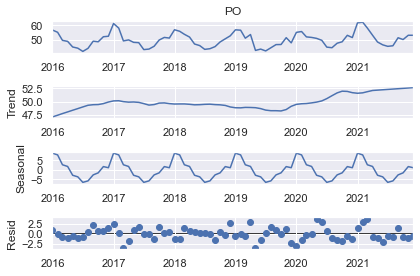

-0.033762951388881766
Киров


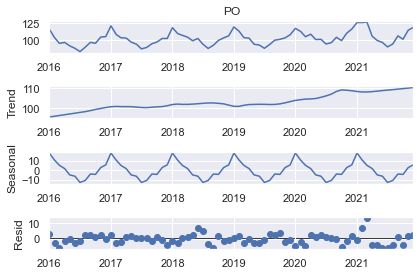

-0.1124765063657269
Коми


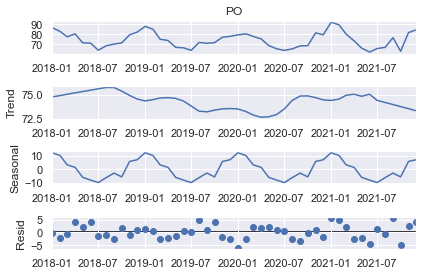

0.17682795902779228
Оренбург


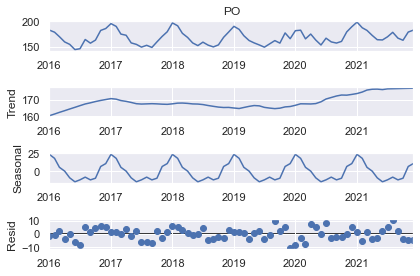

-0.05931021569674377
Свердловск


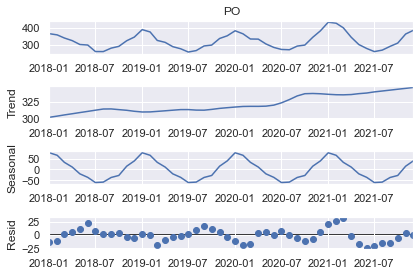

-0.7189006805555636
Удмуртия


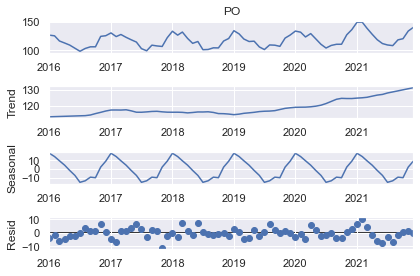

-0.36289736204281364


In [13]:
# Посмотрим, как тренд-сезонность выглядит на графиках

for file in files_excel:
    df = pd.read_excel(path + file)
    df = create_pred_features(df)
    df = df[:-12]
    #df.tail()
    print('='*30)
    print(file.split('.')[0])
    decomposition = seasonal_decompose(df['PO'], model='additive', extrapolate_trend = 1) 
    decomposition.plot()
    pyplot.show()
    print('='*30)
    print(decomposition.resid.mean())


In [14]:
# Попробуем модель SARIMA (модификация ARMA, которая учитывает тренд)

mod = sm.tsa.statespace.SARIMAX(df['PO'][:'2021-12-01'],
                                order=(0, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6346      0.134      4.741      0.000       0.372       0.897
ar.S.L12      -0.2581      0.230     -1.120      0.263      -0.710       0.193
ma.S.L12      -0.0313      0.292     -0.107      0.915      -0.604       0.542
sigma2        31.8471      7.212      4.416      0.000      17.712      45.982


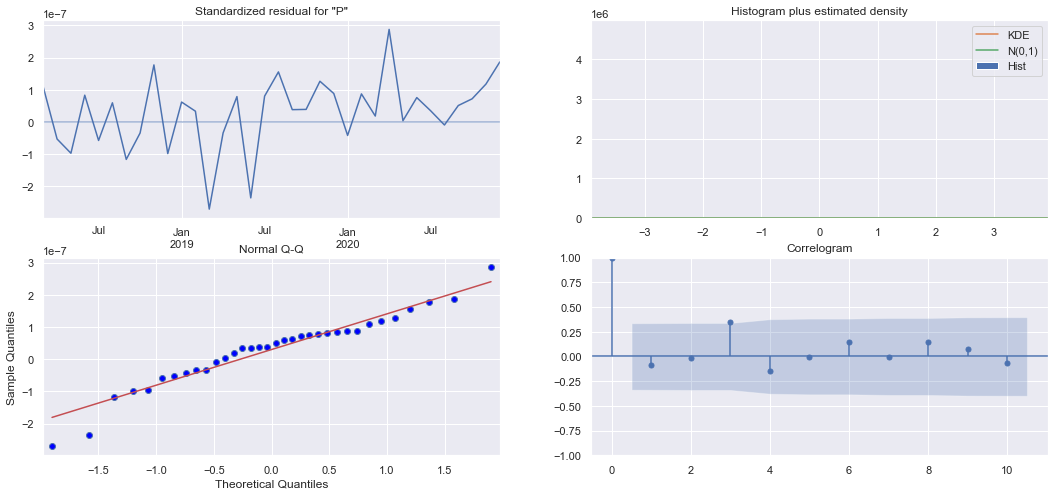

In [7]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [15]:
# Построим модель SARIMA (неплохо работает)
# Рабочая модель SARIMA для прогноза
period = 12
predict = pd.DataFrame()

for file in files_excel:
    df = pd.read_excel(path + file)
    df = create_pred_features(df, period)
    
    
    
#    df = df[:-12]
    #df.tail()

    train = df['PO'][:-1*period]
#    test = df['PO'][-1*period:]
    history = [x for x in train]
    predictions = list()
    for t in range(period):
        model = sm.tsa.statespace.SARIMAX(history,
                                order=(7, 1, 1),
                                seasonal_order=(1, 0, 1, period),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
        
        model_fit = model.fit(disp=-1)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
#        obs = test[t]
#        history.append(obs)
        history.append(yhat)
        
    name = file.split('.')[0]
    predict[name+'_ПО_прогноз'] = predictions
    
    

    
    #если делаем прогноз - надо закоментить:
#    print(file.split('.')[0])
#    print('MAE = {:.2f}'.format(mae(predictions,test)))
#    print('MAPE = {:.2f}'.format(mape(predictions,test)))
#    print('MAE_naiv = {:.2f}'.format(mae(df['PO'][-2*period:-1*period],test)))
#    print('MAPE_naiv = {:.2f}'.format(mape(df['PO'][-2*period:-1*period],test)))
#    print("="*30)
    
#    pyplot.plot(test)
#    pyplot.plot(predict[name+'_ПО_прогноз'], color='red')
#    pyplot.show()
    
#сохраним полученные данные в файл

predict.index = df['date'][-1*period:]
predict.to_excel(excel_writer = path+'prognos_SARIMA_next_period.xlsx')